## Импорт библиотек

In [1]:
import pandas as pd
from pandas import Series
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_validate

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
RANDOM_SEED = 42
!pip freeze > requirements.txt
CURRENT_DATE = pd.to_datetime('07/10/2020')

In [3]:
import warnings
warnings.filterwarnings("ignore")

Функции для визуализации матриц и кривых:

In [4]:
def confusion_matrix_f(columns, d_y, d_y_pred, font_scale=1, normalize=False):
    class_names = np.array(columns, dtype='U10')
    # Plot non-normalized confusion matrix
    plot_confusion_matrix(d_y, d_y_pred, font_scale, classes=class_names,
                          title='Матрица ошибок без нормализации')

    # Plot normalized confusion matrix
    if normalize:
        plot_confusion_matrix(d_y, d_y_pred, font_scale, classes=class_names, normalize=True,
                              title='Нормализованная матрица ошибок')

    plt.show()
    return

def plot_confusion_matrix(y_true, y_pred, font_scale, classes,
                          normalize=False,
                          title=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    list_of_labels = [['TP', 'FP'], ['FN', 'TN']]

    if not title:
        if normalize:
            title = 'Нормализованная матрица ошибок'
        else:
            title = 'Матрица ошибок без нормализации'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    cm[0, 0], cm[1, 1] = cm[1, 1], cm[0, 0]

    # # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.style.use('seaborn-paper')
    cmap = plt.cm.Blues
    color_text = plt.get_cmap('PuBu')(0.85)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.grid(False)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries

           title=title)
    ax.title.set_fontsize(15)
    ax.set_ylabel('Предсказанные значения', fontsize=14, color=color_text)
    ax.set_xlabel('Целевая переменная', fontsize=14, color=color_text)
    ax.set_xticklabels(classes, fontsize=12, color='black')
    ax.set_yticklabels(classes, fontsize=12, color='black')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, list_of_labels[i][j] + '\n' + format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def ROC_curve_with_area(d_y_true, d_y_pred_prob, font_scale):
    roc_auc_score_f = roc_auc_score(d_y_true, d_y_pred_prob)

    plt.style.use('seaborn-paper')
    sns.set(font_scale=font_scale)
    # sns.set_color_codes("muted")

    plt.figure(figsize=(8, 6))
    fpr, tpr, thresholds = roc_curve(d_y_true, d_y_pred_prob, pos_label=1)

    plt.plot(fpr, tpr, lw=3, label='площадь под ROC кривой = %0.3f)' % roc_auc_score_f)
    plt.plot([0, 1], [0, 1], color='grey')
    plt.xlim([-.05, 1.0])
    plt.ylim([-.05, 1.05])
    plt.xlabel('Ложно классифицированные \n False Positive Rate (FPR)')
    plt.ylabel('Верно классифицированные \n True Positive Rate (TPR)')
    plt.title('ROC кривая')
    plt.legend(loc="lower right")
    plt.show()
    return

def PR_curve_with_area(d_y_true, d_y_pred_prob, font_scale=1):
    plt.style.use('seaborn-paper')
    sns.set(font_scale=font_scale)
    # sns.set_color_codes("muted")

    plt.figure(figsize=(8, 6))
    precision, recall, thresholds = precision_recall_curve(d_y_true, d_y_pred_prob, pos_label=1)
    prc_auc_score_f = auc(recall, precision)
    plt.plot(precision, recall, lw=3, label='площадь под PR кривой = %0.3f)' % prc_auc_score_f)

    plt.xlim([-.05, 1.0])
    plt.ylim([-.05, 1.05])
    plt.xlabel('Точность \n Precision = TP/(TP+FP)')
    plt.ylabel('Полнота \n Recall = TP/P')
    plt.title('Precision-Recall кривая')
    plt.legend(loc="upper right")
    plt.show()
    return

def vis_cross_val_score(d_name_metric, d_vec, d_value_metric, font_scale):
    num_folds = len(d_vec['train_score'])
    avg_metric_train, std_metric_train = d_vec['train_score'].mean(), d_vec['train_score'].std()
    avg_metric_test, std_metric_test = d_vec['test_score'].mean(), d_vec['test_score'].std()

    plt.style.use('seaborn-paper')
    sns.set(font_scale=font_scale)
    color_text = plt.get_cmap('PuBu')(0.85)

    plt.figure(figsize=(12, 6))
    plt.plot(d_vec['train_score'], label='тренировочные значения', marker='.', color='darkblue')
    plt.plot([0, num_folds - 1], [avg_metric_train, avg_metric_train], color='blue',
             label='среднее трен. значений ', marker='.', lw=2, ls='--')

    plt.plot(d_vec['test_score'], label='тестовые значения', marker='.', color='red')
    plt.plot([0, num_folds - 1], [avg_metric_test, avg_metric_test], color='lightcoral',
             label='среднее тест. значений ', marker='.', lw=2, ls='--')

    plt.plot([0, num_folds - 1], [d_value_metric, d_value_metric], color='grey',
             label='значение метрики до CV', marker='.', lw=3)

    # plt.xlim([1, num_folds])
    y_max = max(avg_metric_train, avg_metric_test) + 1.5 * max(std_metric_train, std_metric_test)
    y_min = min(avg_metric_train, avg_metric_test) - 3 * max(std_metric_train, std_metric_test)
    plt.ylim([y_min, y_max])
    plt.xlabel('номер фолда', fontsize=15, color=color_text)
    plt.ylabel(d_name_metric, fontsize=15, color=color_text)
    plt.title(f'Кросс-валидация по метрике {d_name_metric} на {num_folds} фолдах',
              color=color_text, fontsize=17)
    plt.legend(loc="lower right", fontsize=11)
    y_min_text = y_min + 0.5 * max(std_metric_train, std_metric_test)
    plt.text(0, y_min_text,
             f'{d_name_metric} на трейне = {round(avg_metric_train, 3)} +/- '
             f'{round(std_metric_train, 3)} \n{d_name_metric} на тесте    = {round(avg_metric_test, 3)} +/- '
             f'{round(std_metric_test, 3)} \n{d_name_metric} до CV        = {round(d_value_metric, 3)}',
             fontsize=15)
    plt.show()
    return

def print_metrics():
    print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
    print('Precision: %.4f' % precision_score(y_test, y_pred))
    print('Recall: %.4f' % recall_score(y_test, y_pred))
    print('F1: %.4f' % f1_score(y_test, y_pred))

## Импорт данных

In [5]:
# train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
# test= pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', train.shape)
display(train.head())
print('Размерность тестового датасета: ', test.shape)
display(test.head())

Размерность тренировочного датасета:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


Размерность тестового датасета:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [6]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
train['Train'] = 1 # помечаем где у нас трейн
test['Train'] = 0 # помечаем где у нас тест

df = train.append(test, sort=False).reset_index(drop=True) # объединяем

## Первичный анализ и предобработка данных

### Описания полей датасета

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [8]:
df.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default,Train
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,73799.000000,110148.000000
mean,55074.500000,39.249410,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,0.126994,0.669999
std,31797.133063,11.518063,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.332968,0.470215
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000,0.000000
25%,27537.750000,30.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000,0.000000
50%,55074.500000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000,1.000000
75%,82611.250000,48.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000,1.000000
max,110148.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000


Проверим наличие пропусков в датасете

In [9]:
train.isnull().sum(), test.isnull().sum()

(client_id             0
 app_date              0
 education           307
 sex                   0
 age                   0
 car                   0
 car_type              0
 decline_app_cnt       0
 good_work             0
 score_bki             0
 bki_request_cnt       0
 region_rating         0
 home_address          0
 work_address          0
 income                0
 sna                   0
 first_time            0
 foreign_passport      0
 default               0
 Train                 0
 dtype: int64,
 client_id             0
 app_date              0
 education           171
 sex                   0
 age                   0
 car                   0
 car_type              0
 decline_app_cnt       0
 good_work             0
 score_bki             0
 bki_request_cnt       0
 region_rating         0
 home_address          0
 work_address          0
 income                0
 sna                   0
 first_time            0
 foreign_passport      0
 Train                 0
 dtype: in

Для наглядности посмотрим на данный признак на графике

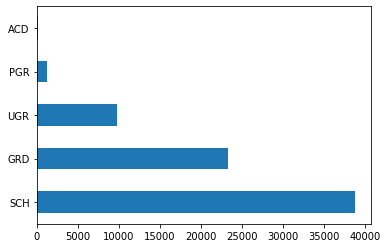

In [10]:
train['education'].value_counts().plot.barh()

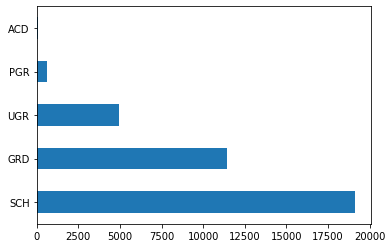

In [11]:
test['education'].value_counts().plot.barh()

Заполним пропуски значением, которое встречается чаще всего

In [12]:
# fill NaN with the most frequent value

import collections

c_1 = collections.Counter(train['education'])
c_2 = collections.Counter(test['education'])

train['education'].fillna(c_1.most_common()[0][0], inplace=True)
test['education'].fillna(c_2.most_common()[0][0], inplace=True)

Проверим успешность заполнения

In [13]:
train.isnull().sum(), test.isnull().sum()

(client_id           0
 app_date            0
 education           0
 sex                 0
 age                 0
 car                 0
 car_type            0
 decline_app_cnt     0
 good_work           0
 score_bki           0
 bki_request_cnt     0
 region_rating       0
 home_address        0
 work_address        0
 income              0
 sna                 0
 first_time          0
 foreign_passport    0
 default             0
 Train               0
 dtype: int64,
 client_id           0
 app_date            0
 education           0
 sex                 0
 age                 0
 car                 0
 car_type            0
 decline_app_cnt     0
 good_work           0
 score_bki           0
 bki_request_cnt     0
 region_rating       0
 home_address        0
 work_address        0
 income              0
 sna                 0
 first_time          0
 foreign_passport    0
 Train               0
 dtype: int64)

Взглянем поближе на признак app_date

In [14]:
train.app_date.head(5), test.app_date.head(5)

(0    01FEB2014
 1    12MAR2014
 2    01FEB2014
 3    23JAN2014
 4    18APR2014
 Name: app_date, dtype: object,
 0    22MAR2014
 1    24JAN2014
 2    23MAR2014
 3    03FEB2014
 4    04FEB2014
 Name: app_date, dtype: object)

Сконветируем формат даты к удобному для работы

In [15]:
# convert to datetime

train.app_date = pd.to_datetime(train.app_date)
test.app_date = pd.to_datetime(train.app_date)
print(train.app_date.head(2))
print(test.app_date.head(2))

0   2014-02-01
1   2014-03-12
Name: app_date, dtype: datetime64[ns]
0   2014-02-01
1   2014-03-12
Name: app_date, dtype: datetime64[ns]


In [16]:
train.head(2)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train
0,25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1
1,63161,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1


На основе признака app_date создадим новые признаки

In [17]:
current_date = pd.to_datetime('28JUL2020')

# Количество дней, прошедших со дня подачи заявки

train['days_passed'] = (current_date - train.app_date).dt.days
test['days_passed'] = (current_date - test.app_date).dt.days

# Месяц подачи заявки

train['app_date_month'] = train.app_date.dt.month
test['app_date_month'] = test.app_date.dt.month

### Добавление новых признаков

Были протестированы разные варианты сочетаний признаков, из всех опробованных к улучшению модели ведет только один: объеденение признаков 'work_address' и 'home_address' в один 'work_home'.

In [18]:
train.loc[train.work_address==1, 'work_address'] = 'w1'
train.loc[train.work_address==2, 'work_address'] = 'w2'
train.loc[train.work_address==3, 'work_address'] = 'w3'
train.loc[train.home_address==1, 'home_address'] = 'h1'
train.loc[train.home_address==2, 'home_address'] = 'h2'
train.loc[train.home_address==3, 'home_address'] = 'h3'
train['work_home'] = train['work_address'] + train['home_address']
train.drop(columns=['home_address', 'work_address'], inplace=True)

test.loc[test.work_address==1, 'work_address'] = 'w1'
test.loc[test.work_address==2, 'work_address'] = 'w2'
test.loc[test.work_address==3, 'work_address'] = 'w3'
test.loc[test.home_address==1, 'home_address'] = 'h1'
test.loc[test.home_address==2, 'home_address'] = 'h2'
test.loc[test.home_address==3, 'home_address'] = 'h3'
test['work_home'] = test['work_address'] + test['home_address']
test.drop(columns=['home_address', 'work_address'], inplace=True)

Полученные признаки сгруппируем в три категории по типу их обработки (категориальные, бинарные и числовые) для дальнейшего удобного анализа.

In [19]:
train.head(2)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,sna,first_time,foreign_passport,default,Train,days_passed,app_date_month,work_home
0,25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,1,50,18000,4,1,N,0,1,2369,2,w2h1
1,63161,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,3,50,19000,4,1,N,0,1,2330,3,w3h2


In [20]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['app_date_month', 'education', 'work_home', 'sna', 'first_time']
num_cols = ['days_passed', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'region_rating', 'income']

## Визуализация

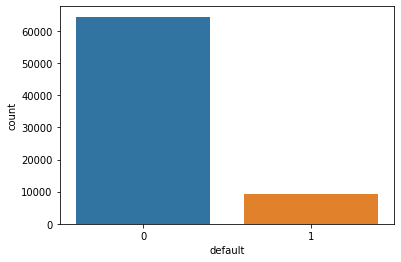

In [21]:
sns.countplot(train['default'])

In [22]:
train['default'].value_counts()

0    64427
1     9372
Name: default, dtype: int64

Очевидно что выборка распределена неравномерно и недефолтных клиентов заметно больше

Построим графики распределения численных переменных

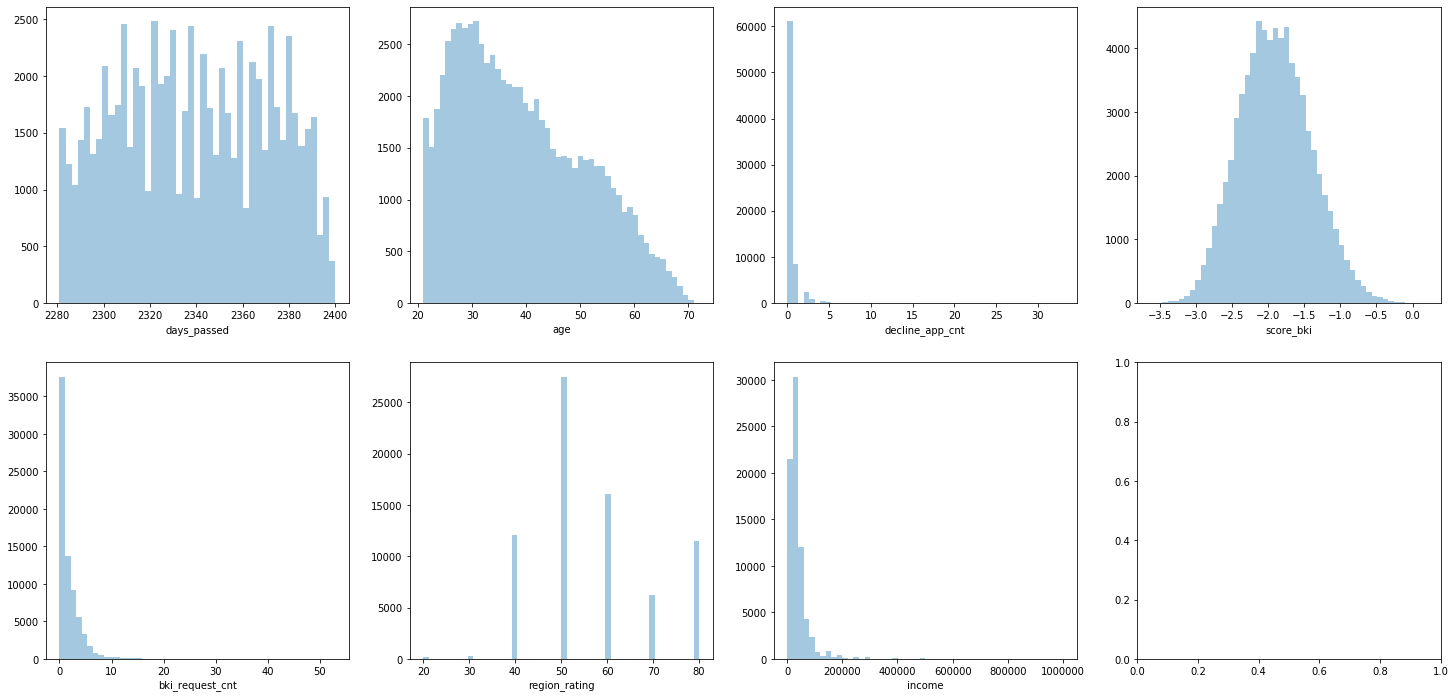

In [23]:
fig, axes = plt.subplots(2, 4, figsize=(25,12))
for col, i in zip(num_cols, range(7)):
    sns.distplot(train[col], kde=False, ax=axes.flat[i])

Прологарифмируем переменные, которые вызывают вопросы в распределении

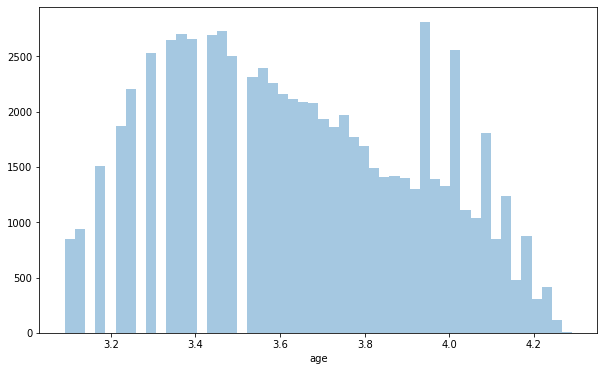

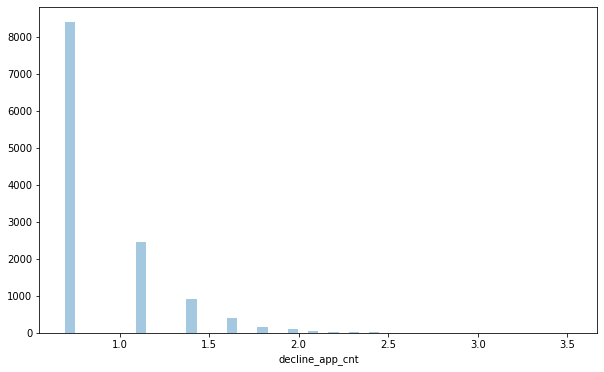

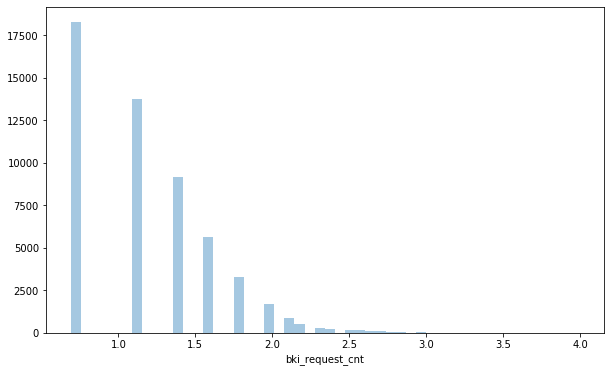

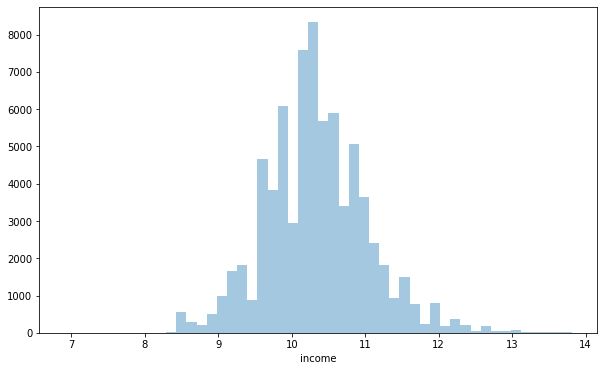

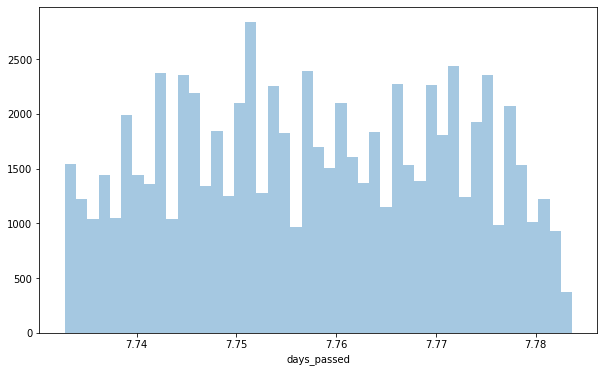

In [24]:
num_cols_log = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'days_passed']
for i in num_cols_log:
    train[i] = np.log(train[i] + 1)
    plt.figure(figsize=(10,6))
    sns.distplot(train[i][train[i] > 0].dropna(), kde = False, rug=False)
    plt.show()

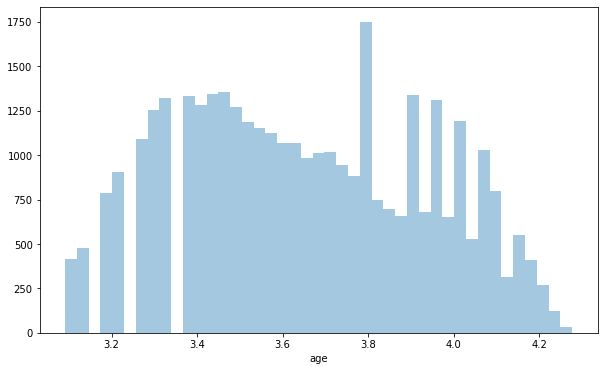

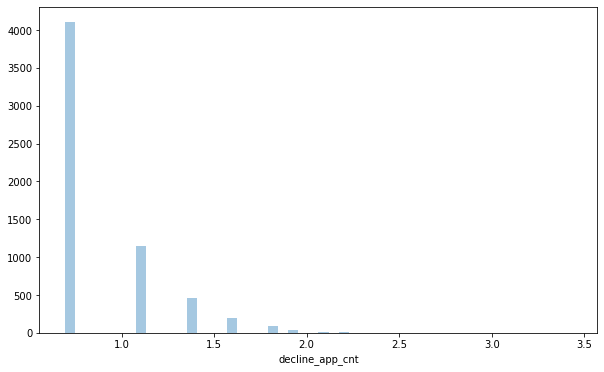

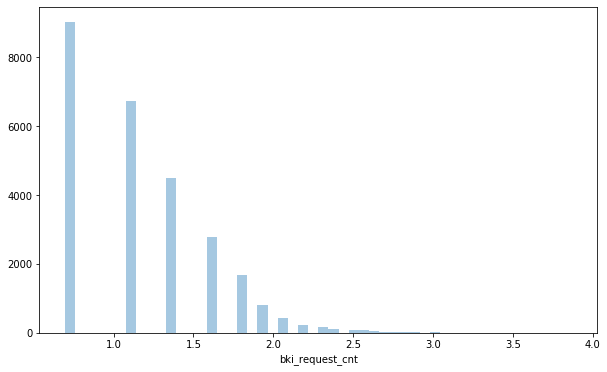

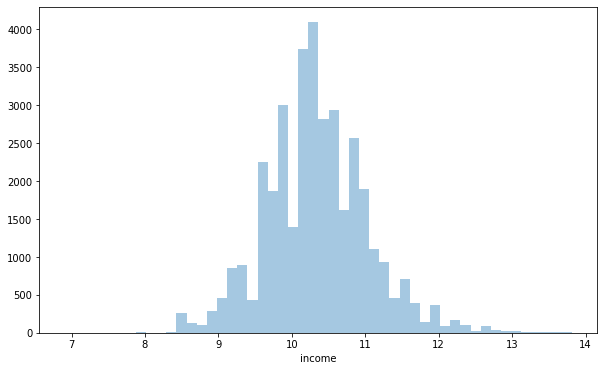

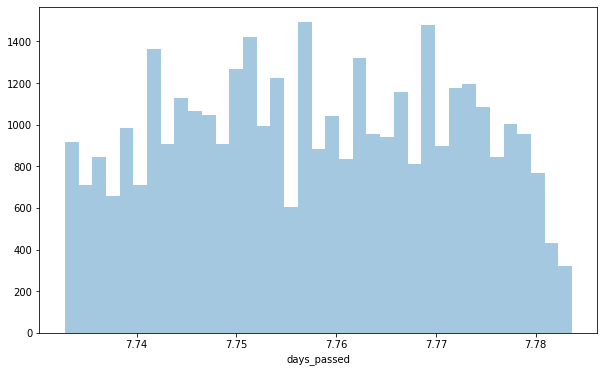

In [25]:
for i in num_cols_log:
    test[i] = np.log(test[i] + 1)
    plt.figure(figsize=(10,6))
    sns.distplot(test[i][test[i] > 0].dropna(), kde = False, rug=False)
    plt.show()

Построим матрицу корреляций

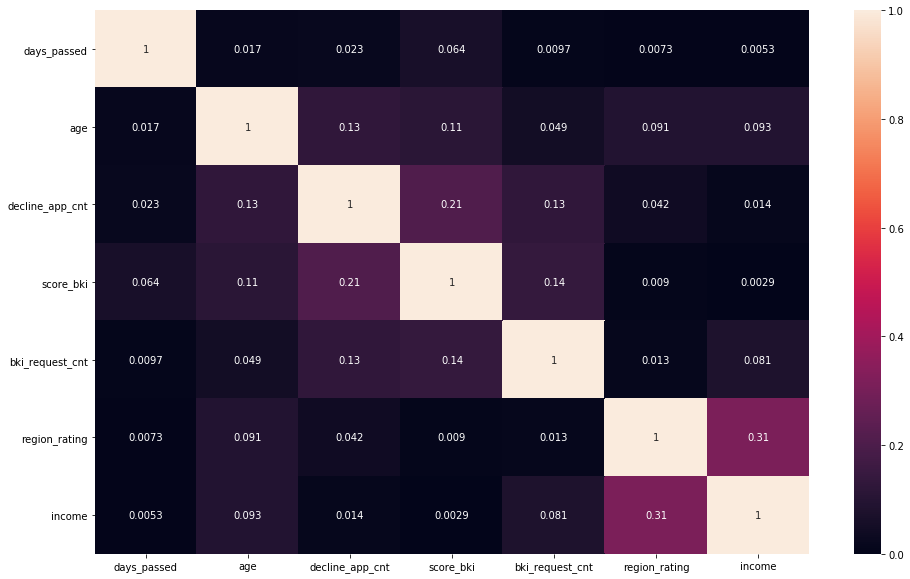

In [26]:
plt.figure(figsize=(16,10))
sns.heatmap(train[num_cols].corr().abs(), vmin=0, vmax=1, annot=True)

Высокой корреляции между признаками не наблюдается

Проанализируем боксплоты для численных переменных

In [27]:
num_cols

['days_passed',
 'age',
 'decline_app_cnt',
 'score_bki',
 'bki_request_cnt',
 'region_rating',
 'income']

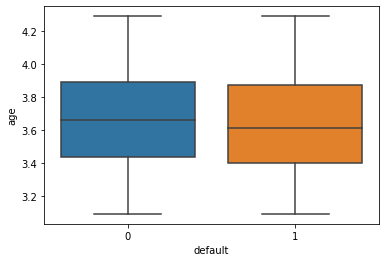

In [28]:
sns.boxplot(x=train.default, y=train.age)

Недефолтные клиенты в среднем старше дефолтных

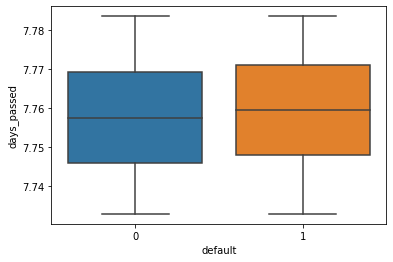

In [29]:
sns.boxplot(x=train.default, y=train.days_passed)

Дефолтные клиенты в среднем оформляли заявки раньше, чем недефолтные. Это может быть связано со множеством факторов, вплоть до эффективности работы системы скоринга в банке в разные моменты времени. Но разница не настолько значительная, чтобы делать какие либо выводы.

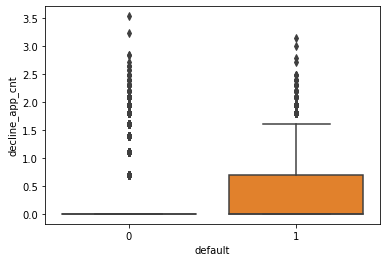

In [30]:
sns.boxplot(x=train.default, y=train.decline_app_cnt)

У дефолтных клиентов количество отклоненных заявок выше, чем у недефолтных

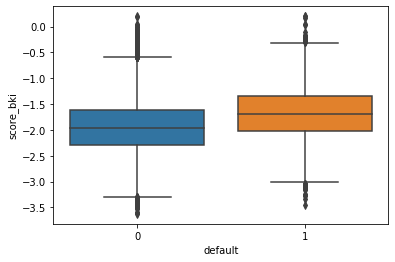

In [31]:
sns.boxplot(x=train.default, y=train.score_bki)

Скоринговый балл в среднем выше у дефолтных клиентов, что довольно необычно (вероятнее всего банк самостоятельно произвел манипуляции с этим признаком, т. к. обычно скоринговый балл положительный от 0 до 850)

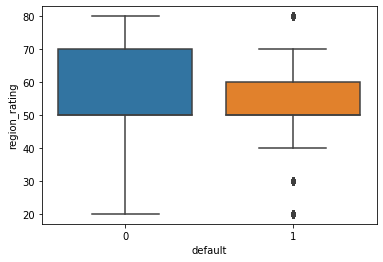

In [32]:
sns.boxplot(x=train.default, y=train.region_rating)

Среднее значение в данном случае больше у недефолтных клиентов, в то время как медианы равны

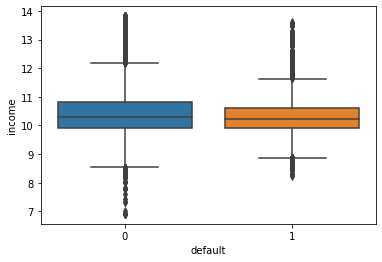

In [33]:
sns.boxplot(x=train.default, y=train.income)

Доход недефолтных клиентов выше, чем доход дефолтных

## Преобразование бинарных и категориальных переменных

Преобразуем бинарные переменные при помощи класса LabelEncoder

In [34]:
label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    test[column] = label_encoder.fit_transform(test[column])
    
train['work_home'] = label_encoder.fit_transform(train['work_home'])
test['work_home'] = label_encoder.fit_transform(test['work_home']) 

# убедимся в преобразовании    
display(train.head())
display(test.head())

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,sna,first_time,foreign_passport,default,Train,days_passed,app_date_month,work_home
0,25905,2014-02-01,SCH,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,50,9.798183,4,1,0,0,1,7.770645,2,3
1,63161,2014-03-12,SCH,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,50,9.852247,4,1,0,0,1,7.754053,3,7
2,25887,2014-02-01,SCH,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,80,10.308986,1,4,1,0,1,7.770645,2,3
3,16222,2014-01-23,SCH,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,50,9.210440,1,3,0,0,1,7.774436,1,7
4,101655,2014-04-18,GRD,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,60,10.308986,1,4,1,0,1,7.738052,4,7


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,sna,first_time,foreign_passport,Train,days_passed,app_date_month,work_home
0,74835,2014-02-01,GRD,1,3.401197,1,1,0.000000,0,-2.271884,1.386294,50,10.819798,1,4,0,0,7.770645,2,3
1,17527,2014-03-12,SCH,0,3.688879,0,0,1.791759,0,-1.504999,1.098612,50,8.517393,4,3,0,0,7.754053,3,3
2,75683,2014-02-01,UGR,1,3.931826,1,1,0.000000,0,-1.691339,0.693147,50,10.308986,1,3,1,0,7.770645,2,3
3,26883,2014-01-23,SCH,1,4.043051,0,0,0.000000,0,-2.374182,0.693147,40,9.741027,1,3,0,0,7.774436,1,3
4,28862,2014-04-18,GRD,0,3.663562,0,0,0.000000,0,-2.487502,0.000000,80,11.695255,1,3,0,0,7.738052,4,7


Преобразуем категориальные переменные при помощи OneHotEncoder

In [35]:
x_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)
y_cat = OneHotEncoder(sparse = False).fit_transform(test[cat_cols].values)

print(x_cat.shape)
print(y_cat.shape)

(73799, 26)
(36349, 26)


In [36]:
education_dummy = pd.get_dummies(train['education'])
education_dummy.head()

,ACD,GRD,PGR,SCH,UGR
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,1,0,0,0


### Значимость непрерывных переменных

Text(0.5, 0, 'F-value')

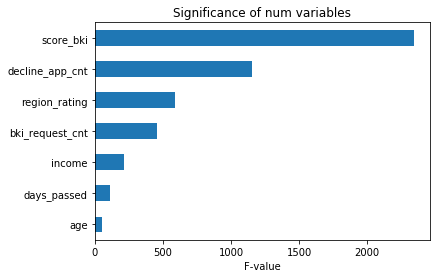

In [37]:
imp_num = Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
plt.title('Significance of num variables')
plt.xlabel('F-value')

### Значимость бинарных и категориальных переменных

Text(0.5, 1.0, 'Significance of bin variables')

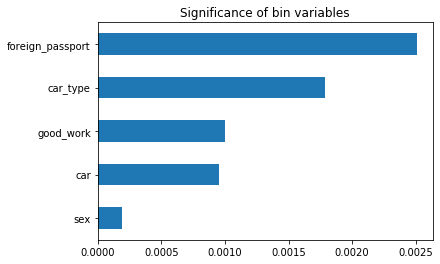

In [38]:
# Значимость бинарных признаков

imp_bin = Series(mutual_info_classif(train[bin_cols], train['default'],
                                     discrete_features =True), index = bin_cols)
imp_bin.sort_values(inplace = True)
imp_bin.plot(kind = 'barh')
plt.title('Significance of bin variables')

Text(0.5, 1.0, 'Significance of cat variables')

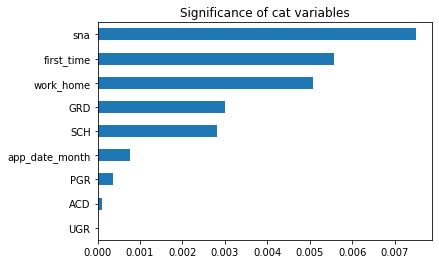

In [39]:
# Значимость категориальных признаков

new_cat_cols = ['app_date_month', 'work_home', 'sna', 'first_time']

imp_cat = pd.Series(mutual_info_classif(pd.concat([train[new_cat_cols], education_dummy], axis=1),
                                        train['default'], discrete_features =True),
                    index = pd.concat([train[new_cat_cols], education_dummy], axis=1).columns)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')
plt.title('Significance of cat variables')

Исходя из данных графиков можно сделать вывод о малозначимости признака sex и age. А также мы можем увидеть значимость различных степеней образования на наш результат и наибольший вклад приносит признак GRD (graduate).

## Подготовка данных к машинному обучению

In [40]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

x_tr = poly.fit_transform(train[num_cols].values)
y_test = poly.fit_transform(test[num_cols].values)

Стандартизируем числовые переменные

In [41]:
# Scaling num variables

x_num = StandardScaler().fit_transform(x_tr)
y_num = StandardScaler().fit_transform(y_test)
print(x_num)
print(y_num)

[[ 0.          0.93590905  1.71113664 ... -0.56439672 -0.64537197
  -0.7868588 ]
 [ 0.         -0.2727367   1.5399884  ... -0.56439672 -0.62789392
  -0.71429225]
 [ 0.          0.93590905 -1.39343857 ...  1.91366223  1.51939095
  -0.08530891]
 ...
 [ 0.         -1.565366   -0.66507223 ...  1.91366223  1.72911286
   0.49692694]
 [ 0.          1.79145135 -0.89146325 ... -0.56439672 -0.75056844
  -1.21518657]
 [ 0.          1.21200216 -0.35072683 ... -0.56439672 -0.53917737
  -0.33979532]]
[[ 0.          0.93955921 -0.88333898 ... -0.56902243 -0.31968854
   0.65637674]
 [ 0.         -0.27334016  0.12606863 ... -0.56902243 -1.06274348
  -2.40227913]
 [ 0.          0.93955921  0.97850869 ... -0.56902243 -0.48454293
  -0.0850894 ]
 ...
 [ 0.         -1.37924378 -0.65688874 ... -0.56902243 -0.260849
   0.92970115]
 [ 0.         -0.46173932 -1.12541848 ...  1.90270276  1.51166781
  -0.0850894 ]
 [ 0.         -1.12498671  0.0372345  ... -0.56902243 -0.70823148
  -1.03384706]]


И объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную.

In [42]:
# Merge

X = np.hstack([x_num, train[bin_cols].values, x_cat])
Y = train['default'].values

id_test = test.client_id
test = np.hstack([y_num, test[bin_cols].values, y_cat])

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42, shuffle = True)

### Регуляризация

In [44]:
from sklearn.model_selection import GridSearchCV

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

penalty = ['l1', 'l2']
hyperparameters = dict(C=C, penalty=penalty)
model = LogisticRegression()
model.fit(X_train, y_train)

clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучший penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучший penalty: l2
Лучшее C: 1291.5496650148827


Обучим модель

In [45]:
lgr = LogisticRegression(penalty = 'l2', C=166.81005372000593, max_iter=500)
lgr.fit(X_train, y_train)

y_pred_prob = lgr.predict_proba(X_test)[:,1]
y_pred = lgr.predict(X_test)

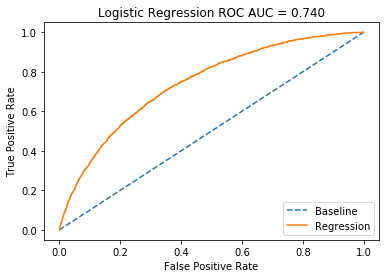

In [46]:
probs = lgr.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

## Оценка качества модели

### Метрики

In [47]:
print_metrics()

Accuracy: 0.8738
Precision: 0.4568
Recall: 0.0266
F1: 0.0503


### Матрица ошибок

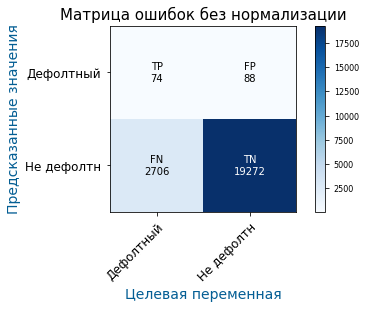

In [48]:
confusion_matrix_f(['Дефолтный','Не дефолтный'], y_test, y_pred, 1, normalize=False)

### ROC-AUC Кривая

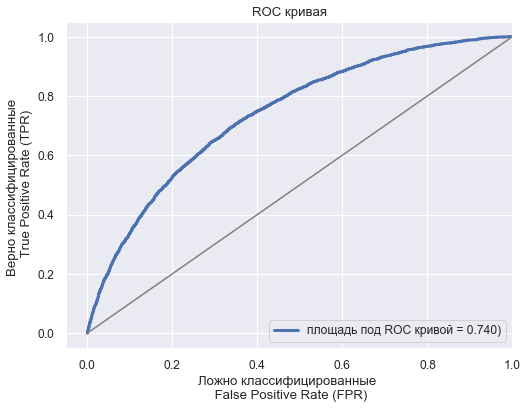

In [49]:
ROC_curve_with_area(y_test, y_pred_prob, 1.1)

Несмотря на хорошие показатель ROC-AUC мы очень плохо угадали дефолтных клинетов, что видно по confusion-matrix и метрике F1

### Precision-Recall кривая

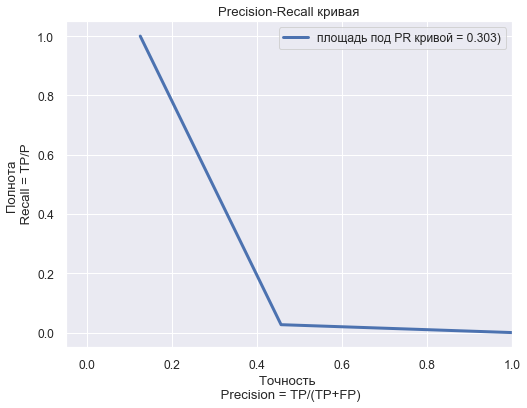

In [50]:
PR_curve_with_area(y_test, y_pred, 1.1)

### Кросс-валидация

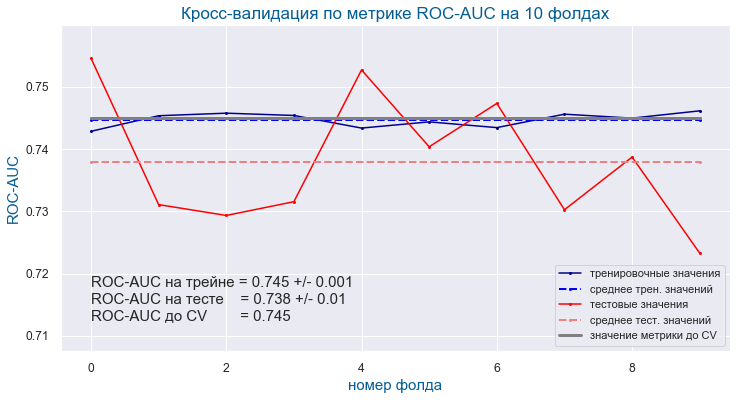

In [51]:
temp_vec = cross_validate(model, X_test, y_test, cv=10, scoring='roc_auc', return_train_score=True);
vis_cross_val_score('ROC-AUC', temp_vec, 0.745, 1.1)

### Промежуточный вывод¶
- Модель получилась очень плохая, несмотря на высокое значений Roc-Auc, мы неугадали дефолтных клиентов (предсказано верно всего 74), об этом свидетельствует низкое значение метрики recall = 0.0266. Большинство клиентов попало в "ошибку второго рода", это означает что банк будет выдавать деньги глиентам, которые не смогут их вернуть.
- Целевая метрика численно получилась хорошей, но не отражает суть. Для этого добавлена кривая precision-recall , площадь под которой получилась очень маленькой. Что показывает, что точность нашего алгоритма маленькая
- Кросс-валидация получила дисперсию 0,01.

## Поиск оптимальных параметров модели

Запускаем GridSearch на небольшом количестве итераций max_iter = 50 с достаточно большой дельтой останова tol1e-3

In [52]:
model = LogisticRegression(random_state=RANDOM_SEED)

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
    ##печатаем метрики
preds = model.predict(X_test)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('Precision: %.4f' % precision_score(y_test, y_pred))
print('Recall: %.4f' % recall_score(y_test, y_pred))
print('F1: %.4f' % f1_score(y_test, y_pred))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l1'
	random_state: 42
	solver: 'liblinear'
	tol: 0.001
	verbose: 0
	warm_start: False
Accuracy: 0.6685
Precision: 0.2282
Recall: 0.6888
F1: 0.3429


Метрика f1 подросла примерно в 7 раз. Построим модель на этих параметрах и посмотрим как это улучшит модель

In [54]:
model = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1, 
                           class_weight= 'balanced', 
                           dual= False, 
                           fit_intercept= True, 
                           intercept_scaling= 1, 
                           l1_ratio= None, 
                           multi_class= 'auto', 
                           n_jobs= None, 
                           penalty= 'l1', 
                           solver = 'liblinear', 
                           verbose= 0, 
                           warm_start= False)

model.fit(X_train, y_train)

y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)
print_metrics()

Accuracy: 0.6686
Precision: 0.2284
Recall: 0.6892
F1: 0.3431


## Оценка качества оптимизированной модели
### Матрица ошибок

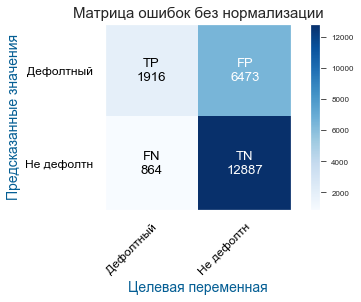

In [55]:
confusion_matrix_f(['Дефолтный','Не дефолтный'], y_test, y_pred, 1, normalize=False)

### ROC-AUC Кривая

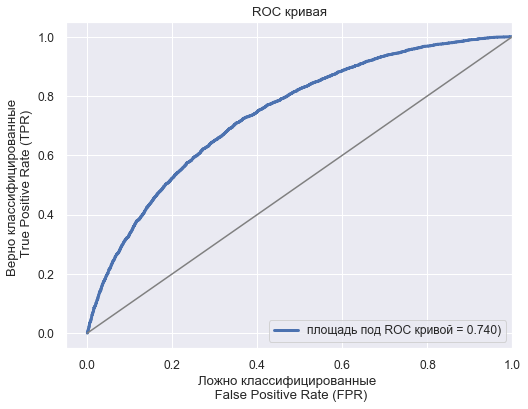

In [56]:
ROC_curve_with_area(y_test, y_pred_prob, 1.1)

### Precision-Recall кривая

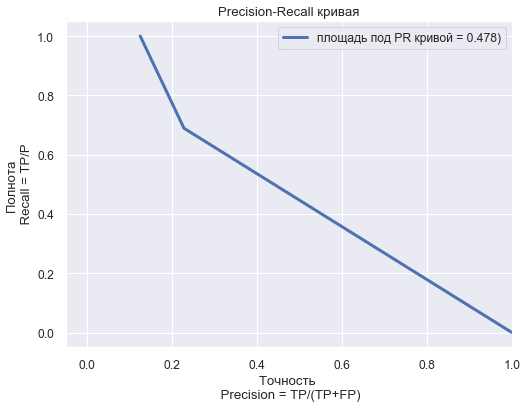

In [57]:
PR_curve_with_area(y_test, y_pred, 1.1)

### Кросс-валидация

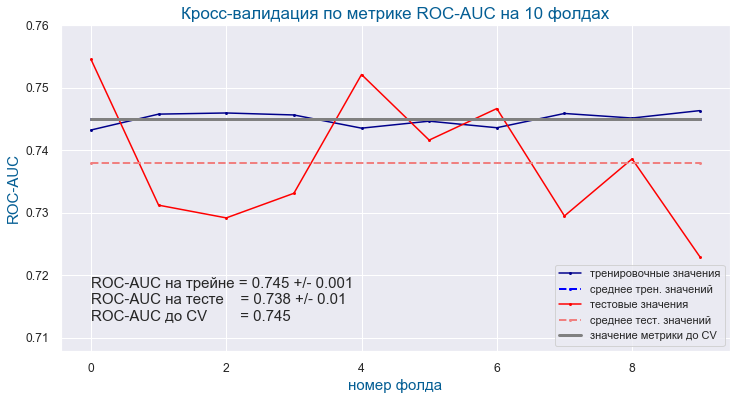

In [58]:
temp_vec = cross_validate(model, X_test, y_test, cv=10, scoring='roc_auc', return_train_score=True);
vis_cross_val_score('ROC-AUC', temp_vec, 0.745, 1.1)

## Сравнение с предыдущей моделью

Recall и f1 заметно выросли, Precision, Accuracy упали, ROC-AUC остался почти на том-же месте. Мы можем ожидать уменьшение ошибки второго рода, что видно из матрицы. 

## Submission

In [60]:
lgr = LogisticRegression(random_state=RANDOM_SEED, 
                           C=1, 
                           class_weight= 'balanced', 
                           dual= False, 
                           fit_intercept= True, 
                           intercept_scaling= 1, 
                           l1_ratio= None, 
                           multi_class= 'auto', 
                           n_jobs= None, 
                           penalty= 'l1', 
                           solver = 'liblinear',
                           verbose= 0, 
                           warm_start= False)
lgr.fit(X, Y)
probs = lgr.predict_proba(test)
probs = probs[:,1]

In [61]:
my_submission = pd.DataFrame({'client_id': id_test, 
                            'default': probs})
my_submission.to_csv('data/submission.csv', index=False)

my_submission

,client_id,default
0,74835,0.259128
1,17527,0.818901
2,75683,0.379077
3,26883,0.366423
4,28862,0.074108
...,...,...
36344,83775,0.832902
36345,106254,0.099923
36346,81852,0.727848
36347,1971,0.616416
